<a href="https://colab.research.google.com/github/Rodrigu87/Module-2-Project-CAS-UniBe/blob/main/Divorce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **MODULE 2 PROJECT**

# The divorce code
*By Kabir, Rodrigue and Sertac*



**Research objectives**

This project aims to advance our understanding of the factors that contribute to divorce.

Specifically, it seeks to:


*   Predict the likelihood of divorce
*  Identify the decisive factors leading to divorce






### Research questions

*   To what extent can demographic, socioeconomic, relational,and psychosocial variables predict the likelihood of divorce among married couples?
*   Which factors are the strongest determinants of divorce in this population?



# **Research hypotheses**

*  H1: Couples who marry at a younger age are significantly more likely to divorce than those who marry later, regardless of income and education.

*   H2: Pre-marital cohabitation increases the risk of divorce in love marriages, but decreases the risk in arranged marriages.


In [9]:
# About the dataset
# synthetic dataset from kaggle.com (https://www.kaggle.com/datasets/vanpatangan/divorce-prediction/data)


In [7]:
import pandas as pd
url = "https://raw.githubusercontent.com/Rodrigu87/Module-2-Project-CAS-UniBe/main/divorce_df.csv"
df = pd.read_csv(url)
df.head(10)

,age_at_marriage,marriage_duration_years,num_children,education_level,employment_status,combined_income,religious_compatibility,cultural_background_match,communication_score,conflict_frequency,...,mental_health_issues,infidelity_occurred,counseling_attended,social_support,shared_hobbies_count,marriage_type,pre_marital_cohabitation,domestic_violence_history,trust_score,divorced
0,30,1,1,Bachelor,Full-time,64001,Different Religion,1,5.536016,3,...,0,0,0,8.428183,5,Love,1,0,6.262411,1
1,27,2,2,Master,Full-time,86221,Same Religion,1,5.810172,3,...,0,1,0,5.297221,1,Love,1,0,6.769384,1
2,31,6,0,High School,Part-time,69441,Same Religion,0,6.088146,3,...,0,0,0,5.887066,1,Arranged,1,0,5.532866,1
3,35,3,2,Bachelor,Full-time,69513,Not Religious,1,6.212046,3,...,0,0,0,5.263555,5,Love,1,0,3.491264,0
4,26,2,2,No Formal Education,Full-time,63986,Different Religion,1,4.826262,1,...,0,0,1,5.771259,4,Love,1,0,10.000000,1
5,26,10,0,High School,Full-time,44605,Same Religion,0,6.825964,3,...,0,0,0,6.909350,3,Love,1,0,4.628149,0
6,35,10,2,High School,Full-time,73454,Different Religion,1,3.775491,1,...,0,0,0,7.351375,1,Love,1,0,5.753932,0
7,31,17,1,High School,Unemployed,59491,Not Religious,1,6.613021,4,...,0,0,0,8.709813,2,Love,0,0,7.010559,1
8,25,5,1,Bachelor,Full-time,40944,Not Religious,0,2.963345,0,...,0,0,0,8.727489,3,Arranged,1,0,2.428385,0
9,30,1,0,PhD,Full-time,46819,Same Religion,1,3.612109,1,...,1,0,0,5.939285,1,Arranged,1,0,8.750676,1


# Descriptive statistics on divorces and non-divorced coupes



---


# Compare divorced vs non-divorced couples on social_support



In [30]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [31]:
# Variables of interest
group_col = "divorced"
vars_to_test = ["social_support"]

# Function to run tests
def compare_groups(df, var, group_col="divorced"):
    print(f"\n===== {var} =====")

# Split groups
Non_divorced = df.loc[df[group_col] == 0, var].dropna()
Divorced = df.loc[df[group_col] == 1, var].dropna()

Shapiro test: p0=0.000, p1=0.000


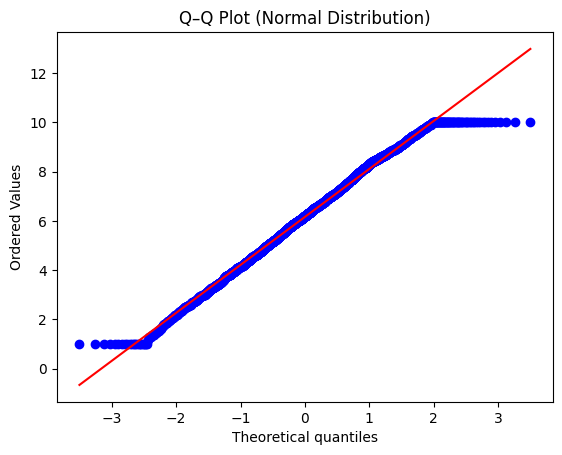

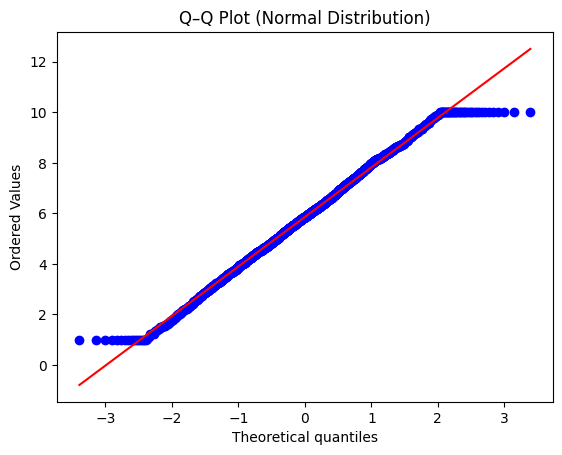

In [37]:
# Check normality (Shapiro-Wilk)
sw_Non_divorced = stats.shapiro(Non_divorced)
sw_Divorced = stats.shapiro(Divorced)
print(f"Shapiro test: p0={sw_Non_divorced.pvalue:.3f}, p1={sw_Divorced.pvalue:.3f}")

stats.probplot(Non_divorced, dist="norm", plot=plt)
plt.title("Q–Q Plot (Normal Distribution)")
plt.show()

stats.probplot(Divorced, dist="norm", plot=plt)
plt.title("Q–Q Plot (Normal Distribution)")
plt.show()

In [21]:





# ---- 2. Check equal variances (Levene’s test)
lev = stats.levene(Non_divorced, Divorced)
print(f"Levene’s test (equal var?): p={lev.pvalue:.3f}")
equal_var = lev.pvalue > 0.05

Group sizes: Not divorced=3009, Divorced=1991
Shapiro test: p0=0.000, p1=0.000
Levene’s test (equal var?): p=0.939


In [9]:
# 2a. Hypothesis test
#H1: Couples who marry at a younger age are significantly more likely to divorce than those who marry later, regardless of income and education.

# ================================
# H1 TEST: Younger age → ↑ divorce (controlling income & education)
# ================================
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_auc_score

# ---- Utility to compute Odds Ratio + CI for a variable
def or_ci_from_result(result, var):
    beta = result.params[var]
    lo, hi = result.conf_int().loc[var]
    return np.exp(beta), np.exp(lo), np.exp(hi), result.pvalues[var]


print("Shape:", df.shape)
print("Target distribution:", df["divorced"].value_counts(normalize=True).round(3).to_dict())

# Keep only what we need for H1
dat = df[["divorced", "age_at_marriage", "combined_income", "education_level"]].dropna().copy()
dat["divorced"] = dat["divorced"].astype(int)
dat["age_at_marriage"] = dat["age_at_marriage"].astype(float)
dat["log_income"] = np.log1p(dat["combined_income"].astype(float))  # robust to skew/zeros
print("Education levels:", sorted(dat["education_level"].unique().tolist()))

# STEP 2 — Assumption check: Linearity of the logit (Box–Tidwell) for age & income
# If the interaction terms are significant (p<0.05), consider non-linear terms for that predictor.
dat["age_log_age"] = dat["age_at_marriage"] * np.log(dat["age_at_marriage"])
dat["log_income_log_log_income"] = dat["log_income"] * np.log(dat["log_income"] + 1e-9)

bt_model = smf.logit(
    "divorced ~ age_at_marriage + age_log_age + log_income + log_income_log_log_income + C(education_level)",
    data=dat
).fit(disp=False)

print("\n[Box–Tidwell terms]")
print(bt_model.summary().tables[1])
print("Interpretation: p<0.05 on 'age_log_age' or 'log_income_log_log_income' suggests nonlinearity.")

# STEP 3 — Main logistic regression (controls: income + education)
# This tests H1 directly with covariate adjustment.
main_model = smf.logit(
    "divorced ~ age_at_marriage + log_income + C(education_level)",
    data=dat
).fit(disp=False)

print("\n[Main logistic regression]")
print(main_model.summary())

# STEP 4 — Hypothesis readout: Odds Ratio & AME for age_at_marriage
or_age, lo_age, hi_age, p_age = or_ci_from_result(main_model, "age_at_marriage")
print(f"\nAge at marriage — OR: {or_age:.3f} (95% CI {lo_age:.3f}–{hi_age:.3f}), p={p_age:.4g}")
print("Interpretation: OR < 1 supports 'younger age → higher divorce odds' (controlling for income & education).")

marg = main_model.get_margeff(at='overall', method='dydx')
print("\n[Average marginal effects]")
print(marg.summary())  # dydx for each predictor; look for age_at_marriage

# STEP 5 — Multicollinearity (VIF) on the design used
X = pd.get_dummies(dat[["age_at_marriage", "log_income", "education_level"]], drop_first=True)
X = add_constant(X)
vif = pd.DataFrame({
    "feature": X.columns,
    "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
}).sort_values("VIF", ascending=False)
print("\n[VIF table] (VIF>5–10 may be concerning)")
print(vif.to_string(index=False))

# STEP 6 — Discrimination (AUC; in-sample is fine for hypothesis testing)
pred_prob = main_model.predict()
auc = roc_auc_score(dat["divorced"], pred_prob)
print(f"\nIn-sample AUC: {auc:.3f}")

Shape: (5000, 22)
Target distribution: {0: 0.602, 1: 0.398}
Education levels: ['Bachelor', 'High School', 'Master', 'No Formal Education', 'PhD']

[Box–Tidwell terms]
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                   -10.2965     24.059     -0.428      0.669     -57.452      36.859
C(education_level)[T.High School]             0.0529      0.069      0.763      0.445      -0.083       0.189
C(education_level)[T.Master]                  0.1249      0.079      1.573      0.116      -0.031       0.281
C(education_level)[T.No Formal Education]    -0.1805      0.146     -1.241      0.215      -0.466       0.105
C(education_level)[T.PhD]                     0.2771      0.142      1.956      0.050      -0.001       0.555
age_at_marriage                              -0.3322      0.224

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [13]:
# 2b. Hypothesis test
#H2: Pre-marital cohabitation increases the risk of divorce in love marriages, but decreases the risk in arranged marriages.
# H2 TEST: "Pre-marital cohabitation increases divorce risk in LOVE marriages,
#          but decreases it in ARRANGED marriages."

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_auc_score

# -----------------------------
# STEP 1 — Load & minimal inspect
# -----------------------------
print("Shape:", df.shape)
print("Marriage types:", df["marriage_type"].value_counts().to_dict())
print("Premarital cohabitation:", df["pre_marital_cohabitation"].value_counts().to_dict())
print("Target distribution (divorced):", df["divorced"].value_counts(normalize=True).round(3).to_dict())

# -----------------------------
# STEP 2 — Keep variables & clean
# -----------------------------
cols = [
    "divorced", "pre_marital_cohabitation", "marriage_type",
    "age_at_marriage", "combined_income", "education_level"
]
dat = df[cols].dropna().copy()
dat["divorced"] = dat["divorced"].astype(int)
dat["pre_marital_cohabitation"] = dat["pre_marital_cohabitation"].astype(int)
dat["age_at_marriage"] = dat["age_at_marriage"].astype(float)
dat["log_income"] = np.log1p(dat["combined_income"].astype(float))  # control for skew

# -----------------------------
# STEP 3 — Logit with interaction (Arranged as reference)
# -----------------------------
formula = (
    "divorced ~ pre_marital_cohabitation "
    "* C(marriage_type, Treatment(reference='Arranged')) "
    "+ age_at_marriage + log_income + C(education_level)"
)
model = smf.logit(formula, data=dat).fit(disp=False)
print("\n[Logit: cohab × marriage_type + controls]")
print(model.summary())

# -----------------------------
# STEP 4 — Simple effects of cohab within each marriage type
# Arranged: beta = coef(cohab)
# Love:     beta = coef(cohab) + coef(cohab:Love)
# (Convert to OR with 95% CI)
# -----------------------------
params = model.params
cov = model.cov_params()
names = params.index.tolist()

def or_ci_for_linear_combo(L, params, cov, z=1.96):
    est = float(np.dot(L, params))
    se = float(np.sqrt(np.dot(L, np.dot(cov, L))))
    lo, hi = est - z*se, est + z*se
    return np.exp(est), np.exp(lo), np.exp(hi), est, se

# Main effect (Arranged baseline)
idx_cohab = names.index("pre_marital_cohabitation")
L_arranged = np.zeros(len(names)); L_arranged[idx_cohab] = 1.0
orA, loA, hiA, estA, seA = or_ci_for_linear_combo(L_arranged, params.values, cov.values)
print("\n[Simple effect of premarital cohabitation]")
print(f"ARRANGED — beta={estA:.3f} (SE={seA:.3f}); OR={orA:.3f} (95% CI {loA:.3f}–{hiA:.3f})")

# Love interaction term name (as created by the formula)
int_name_love = "pre_marital_cohabitation:C(marriage_type, Treatment(reference='Arranged'))[T.Love]"
if int_name_love in names:
    L_love = np.zeros(len(names))
    L_love[idx_cohab] = 1.0
    L_love[names.index(int_name_love)] = 1.0
    orL, loL, hiL, estL, seL = or_ci_for_linear_combo(L_love, params.values, cov.values)
    print(f"LOVE     — beta={estL:.3f} (SE={seL:.3f}); OR={orL:.3f} (95% CI {loL:.3f}–{hiL:.3f})")
else:
    print("LOVE     — interaction term not found; check categories in 'marriage_type'.")

# -----------------------------
# STEP 5 — Test the interaction (is effect different in Love vs Arranged?)
# -----------------------------
if int_name_love in names:
    w = model.wald_test(np.eye(len(names))[names.index(int_name_love)])
    print("\n[Wald test for interaction (Love vs Arranged)]")
    print(w)

# -----------------------------
# STEP 6 — Multicollinearity (VIF) on the design matrix
# -----------------------------
y, X = model.model.endog, model.model.exog
vif = pd.DataFrame({
    "feature": names,
    "VIF": [variance_inflation_factor(X, i) for i in range(X.shape[1])]
}).sort_values("VIF", ascending=False)
print("\n[VIF table]")
print(vif.to_string(index=False))

# -----------------------------
# STEP 7 — Predicted probabilities for a typical case
# -----------------------------
modal_edu = dat["education_level"].mode().iat[0]
mean_age = dat["age_at_marriage"].mean()
mean_log_inc = dat["log_income"].mean()

def pred_prob(marriage_type, cohab):
    d = {
        "pre_marital_cohabitation": [cohab],
        "marriage_type": [marriage_type],
        "age_at_marriage": [mean_age],
        "log_income": [mean_log_inc],
        "education_level": [modal_edu],
    }
    return float(model.predict(pd.DataFrame(d)).values[0])

for mt in ["Arranged", "Love"]:
    if mt in dat["marriage_type"].unique():
        p0, p1 = pred_prob(mt, 0), pred_prob(mt, 1)
        print(f"\nPredicted P(divorce) — {mt}:")
        print(f"  Cohab=0 → {p0:.3f}")
        print(f"  Cohab=1 → {p1:.3f}   Δ={p1 - p0:+.3f}")

# -----------------------------
# STEP 8 — Model discrimination (AUC, in-sample for context)
# -----------------------------
pred = model.predict()
auc = roc_auc_score(dat["divorced"], pred)
print(f"\nAUC (in-sample): {auc:.3f}")


Shape: (5000, 22)
Marriage types: {'Love': 3513, 'Arranged': 1231, 'Other': 256}
Premarital cohabitation: {1: 2961, 0: 2039}
Target distribution (divorced): {0: 0.602, 1: 0.398}

[Logit: cohab × marriage_type + controls]
                           Logit Regression Results                           
Dep. Variable:               divorced   No. Observations:                 5000
Model:                          Logit   Df Residuals:                     4988
Method:                           MLE   Df Model:                           11
Date:                Wed, 24 Sep 2025   Pseudo R-squ.:                0.002117
Time:                        08:57:37   Log-Likelihood:                -3354.3
converged:                       True   LL-Null:                       -3361.4
Covariance Type:            nonrobust   LLR p-value:                    0.2203
                                                                                          coef    std err          z      P>|z|      [0.025      0.

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
